In [1]:
import numpy as np
np.random.seed(123)

import pandas as pd
import sys
import os
import collections
import configparser
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from sklearn.naive_bayes import BernoulliNB
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from joblib import dump, load
from collections import Counter
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import configparser
import numpy as np
import os

sys.path.append(os.path.abspath('../../Module'))
import preprocessing
import evaluation
import visualize

config = configparser.ConfigParser()
config.read('../../config.ini')
vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
input_dir = vg_json_export + 'feature_arrays/'
input_dir_raw = vg_json_export + 'raw_feature_arrays/'

set_type='dev'
colors = preprocessing.basic_colors()
classifier_list = 'bottomup topdown combined'.split()
num_classes = 11
random_seed = 123

batch_size = 128
num_classes = 11
epochs = 25

import_arrays = np.load(input_dir+'type_to_color_filtered.npz')

Using TensorFlow backend.


In [2]:
def get_sample(n):
    image_dir = config['PATHS']['vg-images']

    all_objects = pd.read_csv(vg_json_export+"extracted_data/all_objects.csv", index_col=0)
    train_objects = pd.read_csv(vg_json_export+"extracted_data/train_df.csv", index_col=0)
    dev_objects = pd.read_csv(vg_json_export+"extracted_data/dev_df.csv", index_col=0)

    import_arrays = np.load(input_dir+'type_to_color_filtered.npz')

    td_train_x = import_arrays['train_x']
    td_train_y = import_arrays['train_y']

    train_y_df = pd.DataFrame(td_train_y[:,1:], columns=colors, index=td_train_y[:,0])
    td_train_y = pd.DataFrame(columns=colors)

    for c in colors:
        td_train_y = td_train_y.append(train_y_df.loc[train_y_df[c] == 1].sample(n, replace=True, random_state=random_seed))

    #td_train_y = td_train_y.sample(len(td_train_y), replace=False, random_state=random_seed)
    td_train_y = np.append(
        np.array(td_train_y.index).reshape(-1,1),
        td_train_y.to_numpy(),
        axis = 1
    )
    td_train_x = pd.DataFrame(td_train_x[:,1:], index=td_train_x[:,0]).loc[td_train_y[:,0]]
    td_train_x = np.append(
        np.array(td_train_x.index).reshape(-1,1),
        td_train_x.to_numpy(),
        axis = 1
    )
    return (td_train_x,td_train_y)

In [3]:
def topdown_predictions(td_train_x, td_train_y):
    dev_x = import_arrays['dev_x']
    dev_y = import_arrays['dev_y']
    # Indizes abtrennen
    train_y_index = td_train_y[:,0:1]
    train_y = td_train_y[:,1:]
    dev_y_index = dev_y[:,0:1]
    dev_y = dev_y[:,1:]

    train_x = td_train_x[:,1:]
    dev_x = dev_x[:,1:]

    # One-Hot-Kodierung -> Int
    train_y = train_y.argmax(axis=1)
    dev_y = dev_y.argmax(axis=1)

    classifier = BernoulliNB()
    classifier.fit(train_x, train_y)
    # Accuracy auf Dev-Set
    score_all = classifier.score(dev_x,dev_y)
    topdown_predict = classifier.predict_proba(dev_x)
    topdown_predict = np.append(dev_y_index, topdown_predict, axis=1)
    
    return (topdown_predict)

In [4]:
def bottomup_predictions(td_train_y):
    dev_y = import_arrays['dev_y']

    # Gezippte Numpy-Archive importieren
    bottomup_arrays = np.load(input_dir_raw+'baseline_arrays_bgr.npz')
    train_bu_x = bottomup_arrays['train_x']
    train_y = td_train_y
    train_ids = train_y[:,0]

    train_bu_x = pd.DataFrame(train_bu_x, index=train_bu_x[:,0]).loc[train_ids].to_numpy()

    test_bu_x = bottomup_arrays[set_type+'_x']
    test_y = dev_y
    test_ids = dev_y[:,0]

    test_bu_x = pd.DataFrame(test_bu_x, index=test_bu_x[:,0]).loc[test_ids].to_numpy()

    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(512,)))
    model.add(Dropout(0.2))
    model.add(Dense(240, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(24, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    history = model.fit(train_bu_x[:,1:], train_y[:,1:],
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(test_bu_x[:,1:], test_y[:,1:])
                       )

    score = model.evaluate(test_bu_x[:,1:], test_y[:,1:], verbose=0)  
    predict_test_y = model.predict(test_bu_x[:,1:])

    return (predict_test_y)

In [5]:
def test_predictions(bottomup_predict, topdown_predict):
    # IDs zu Prediction-Arrays hinzufügen
    ids = topdown_predict[:,0:1]
    bottomup_predict = np.append(ids, bottomup_predict, axis=1)
    topdown_predict = pd.DataFrame(topdown_predict).sort_values(by=0).to_numpy()
    bottomup_predict = pd.DataFrame(bottomup_predict).loc[
        pd.DataFrame(bottomup_predict)[0].isin(topdown_predict[:,0].ravel())
        ].sort_values(by=0).to_numpy()
    topdown_predict = pd.DataFrame(topdown_predict).loc[
        pd.DataFrame(topdown_predict)[0].isin(bottomup_predict[:,0].ravel())
        ].sort_values(by=0).to_numpy()
    ids = topdown_predict[:,0].reshape(-1,1)

    combined_predict = (bottomup_predict[:,1:] + topdown_predict[:,1:]) / 2
    combined_predict = np.append(ids, combined_predict, axis=1)

    all_obj = pd.read_csv(vg_json_export+"extracted_data/all_objects.csv", index_col=0)
    test_obj = pd.read_csv(vg_json_export+"extracted_data/"+set_type+"_df.csv", index_col=0)

    # Frequente Objekte + CDOs + CNOs:
    frequent_objects, color_diagnostic_objects, color_biased_objects, color_neutral_objects = preprocessing.freq_cdo_cno(all_obj, num_cdos=100, num_cnos=100, min_num=100)
    # DataFrame mit Objekten aus Prediction-Arrays
    pred_obj = all_obj.loc[combined_predict[:,0]]
    # DataFrames für CDOs, CBOs und CNOs
    cd_obj = pred_obj.loc[pred_obj.object_name.isin(color_diagnostic_objects.keys())]
    cb_obj = pred_obj.loc[pred_obj.object_name.isin(color_biased_objects)]
    cn_obj = pred_obj.loc[pred_obj.object_name.isin(color_neutral_objects)]

    # DataFrames aus Predictions (np-Arrays) erstellen
    bottomup_predict_df =  pd.DataFrame(data=bottomup_predict[0:,1:],index=bottomup_predict[0:,0],columns=colors).sort_index().astype('float')
    topdown_predict_df =  pd.DataFrame(data=topdown_predict[0:,1:],index=topdown_predict[0:,0],columns=colors).sort_index().astype('float')
    combined_predict_df =  pd.DataFrame(data=combined_predict[0:,1:],index=combined_predict[0:,0],columns=colors).sort_index().astype('float')

    # Farbwort mit höchstem Wert (-> prognostiziertes Farbwort) (ergibt pd.Series)
    pred_label_bottomup = bottomup_predict_df.idxmax(axis=1)
    pred_label_topdown = topdown_predict_df.idxmax(axis=1)
    pred_label_combined = combined_predict_df.idxmax(axis=1)

    # Predictions mit freq_obj kombinieren
    predict_df = pred_obj.copy().sort_index()
    predict_df = predict_df.merge(pred_label_bottomup.rename('bottomup_color'), left_index=True, right_index=True)
    predict_df = predict_df.merge(pred_label_topdown.rename('topdown_color'), left_index=True, right_index=True)
    predict_df = predict_df.merge(pred_label_combined.rename('combined_color'), left_index=True, right_index=True)

    # DFs für CDOs, CNOs und CBOs
    predict_cdo = predict_df.loc[cd_obj.index.to_list()]
    predict_cbo = predict_df.loc[cb_obj.index.to_list()]
    predict_cno = predict_df.loc[cn_obj.index.to_list()]

    accuracy_scores = {} 
    print ('Accuracy')
    for classifier in classifier_list:
        accuracy_scores.update(evaluation.print_scores(classifier, column=classifier+'_color', df=predict_df, df_cdo=predict_cdo, df_cno=predict_cno, df_cbo=predict_cbo, return_dict = True, metric='accuracy'))
    # accuracy_scores als LaTeX-Tabelle:
    #print (pd.DataFrame(accuracy_scores).T[['Alle Objekte', 'Color-Diagnostic Objects', 'Color-Biased Objects', 'Color-Neutral Objects']].round(decimals=2).to_latex())

    df = predict_df
    save = True

    for classifier in classifier_list:
        evaluation.plot_confusion_matrix(df['color'], df[classifier+'_color'], classes=colors, normalize=True, title=classifier.capitalize() + ': Predictions', error_matrix=False, cmap=plt.cm.Greys, colorbar=False, save_image=save, file_dir = vg_json_export+'images/')
        #evaluation.plot_confusion_matrix(df['color'], df[classifier+'_color'], classes=colors, normalize=True, title=classifier.capitalize() + ': Errors', error_matrix=True, cmap=plt.cm.Greys, colorbar=False, save_image=save, file_dir = vg_json_export+'images/')

5000 




/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Train-Items: 55000
Items pro Klasse: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000, 10: 5000}


/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Accuracy
bottomup:
Metric: accuracy
{'Alle Objekte': 0.40443715974945854}
{'Color-Diagnostic Objects': 0.4837476099426386}
{'Color-Biased Objects': 0.365441906653426}
{'Color-Neutral Objects': 0.45286624203821657}


topdown:
Metric: accuracy
{'Alle Objekte': 0.36381197681905986}
{'Color-Diagnostic Objects': 0.765774378585086}
{'Color-Biased Objects': 0.28798411122144985}
{'Color-Neutral Objects': 0.21146496815286625}


combined:
Metric: accuracy
{'Alle Objekte': 0.5089270034537259}
{'Color-Diagnostic Objects': 0.7595602294455067}
{'Color-Biased Objects': 0.4215491559086395}
{'Color-Neutral Objects': 0.4745222929936306}




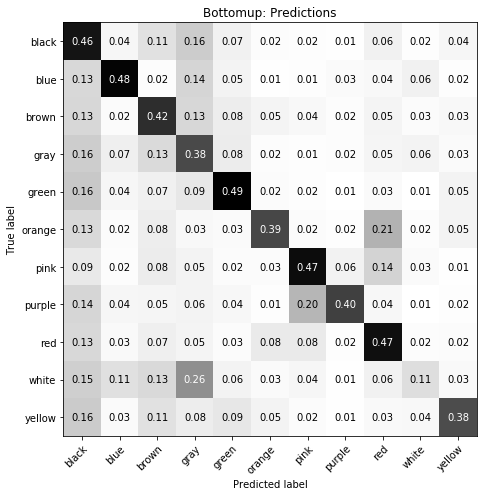

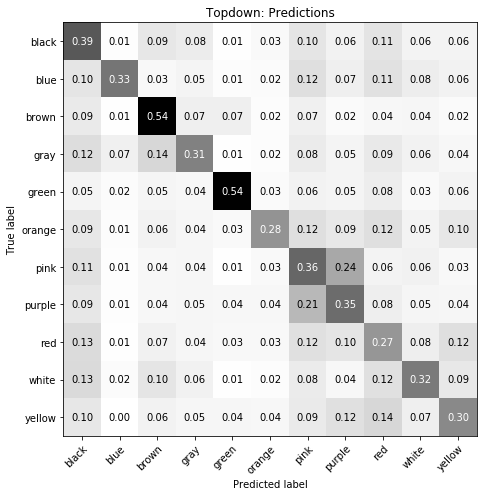

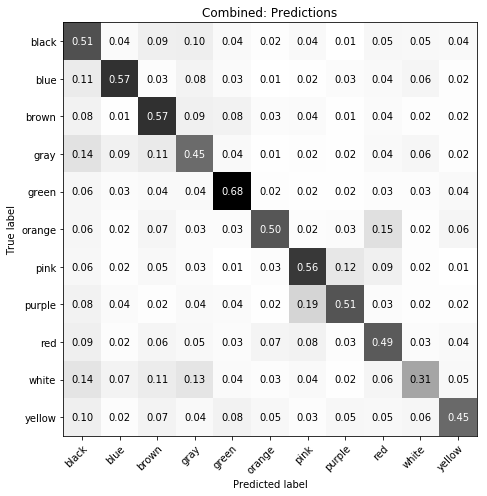





10000 




/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Train-Items: 110000
Items pro Klasse: {0: 10000, 1: 10000, 2: 10000, 3: 10000, 4: 10000, 5: 10000, 6: 10000, 7: 10000, 8: 10000, 9: 10000, 10: 10000}


/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Accuracy
bottomup:
Metric: accuracy
{'Alle Objekte': 0.4272668734999707}
{'Color-Diagnostic Objects': 0.48565965583174}
{'Color-Biased Objects': 0.3853028798411122}
{'Color-Neutral Objects': 0.4786624203821656}


topdown:
Metric: accuracy
{'Alle Objekte': 0.36773400456594274}
{'Color-Diagnostic Objects': 0.7662523900573613}
{'Color-Biased Objects': 0.2899702085402185}
{'Color-Neutral Objects': 0.21560509554140128}


combined:
Metric: accuracy
{'Alle Objekte': 0.5278346894573552}
{'Color-Diagnostic Objects': 0.7619502868068834}
{'Color-Biased Objects': 0.43445878848063557}
{'Color-Neutral Objects': 0.5070063694267516}




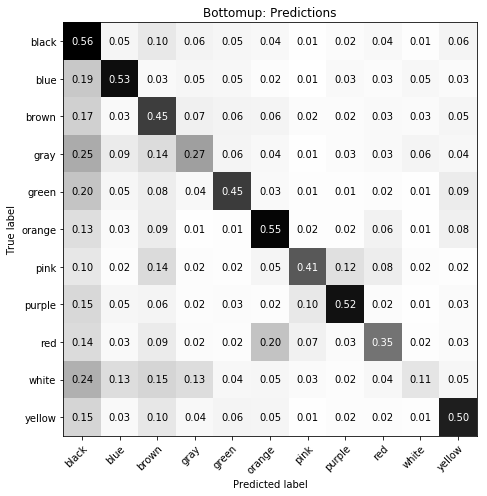

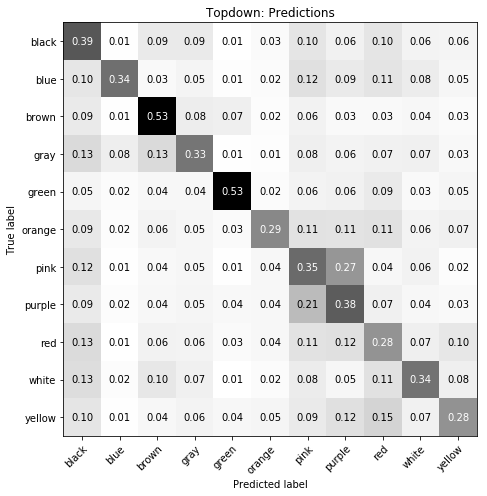

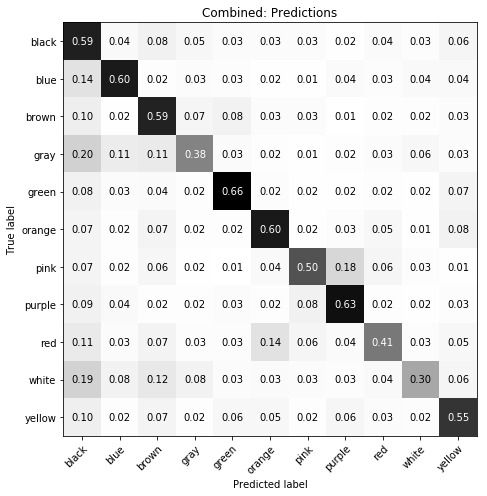





15000 




/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Train-Items: 165000
Items pro Klasse: {0: 15000, 1: 15000, 2: 15000, 3: 15000, 4: 15000, 5: 15000, 6: 15000, 7: 15000, 8: 15000, 9: 15000, 10: 15000}


/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Accuracy
bottomup:
Metric: accuracy
{'Alle Objekte': 0.45003804952291754}
{'Color-Diagnostic Objects': 0.504302103250478}
{'Color-Biased Objects': 0.4041708043694141}
{'Color-Neutral Objects': 0.5044585987261146}


topdown:
Metric: accuracy
{'Alle Objekte': 0.36913891002751276}
{'Color-Diagnostic Objects': 0.765774378585086}
{'Color-Biased Objects': 0.30536246276067525}
{'Color-Neutral Objects': 0.2197452229299363}


combined:
Metric: accuracy
{'Alle Objekte': 0.5400690745185271}
{'Color-Diagnostic Objects': 0.7624282982791587}
{'Color-Biased Objects': 0.4637537239324727}
{'Color-Neutral Objects': 0.5257961783439491}




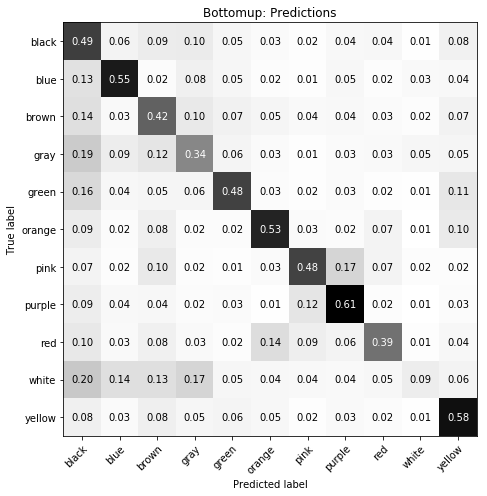

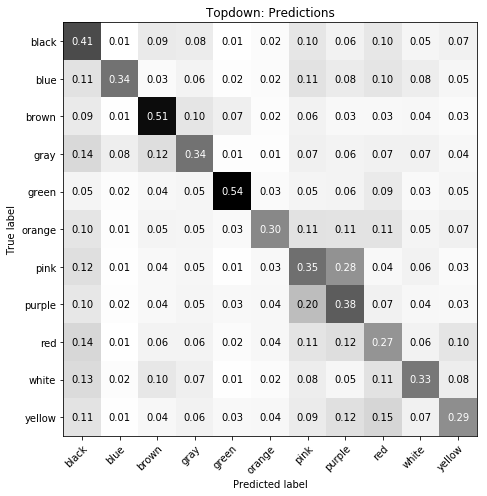

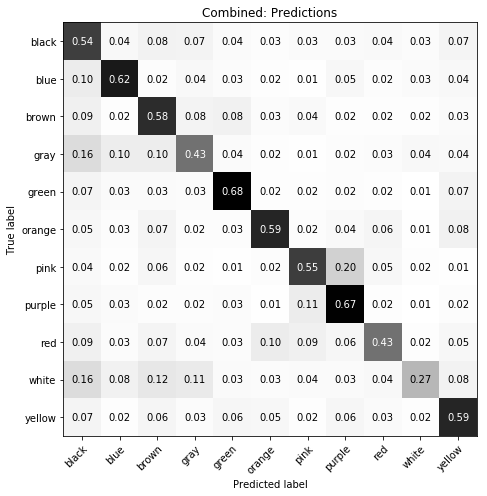





20000 




/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Train-Items: 220000
Items pro Klasse: {0: 20000, 1: 20000, 2: 20000, 3: 20000, 4: 20000, 5: 20000, 6: 20000, 7: 20000, 8: 20000, 9: 20000, 10: 20000}


/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Accuracy
bottomup:
Metric: accuracy
{'Alle Objekte': 0.455599133641632}
{'Color-Diagnostic Objects': 0.5578393881453155}
{'Color-Biased Objects': 0.3997020854021847}
{'Color-Neutral Objects': 0.5124203821656051}


topdown:
Metric: accuracy
{'Alle Objekte': 0.3713633436749985}
{'Color-Diagnostic Objects': 0.765774378585086}
{'Color-Biased Objects': 0.3073485600794439}
{'Color-Neutral Objects': 0.22165605095541402}


combined:
Metric: accuracy
{'Alle Objekte': 0.5473277527366388}
{'Color-Diagnostic Objects': 0.7662523900573613}
{'Color-Biased Objects': 0.4682224428997021}
{'Color-Neutral Objects': 0.5340764331210192}




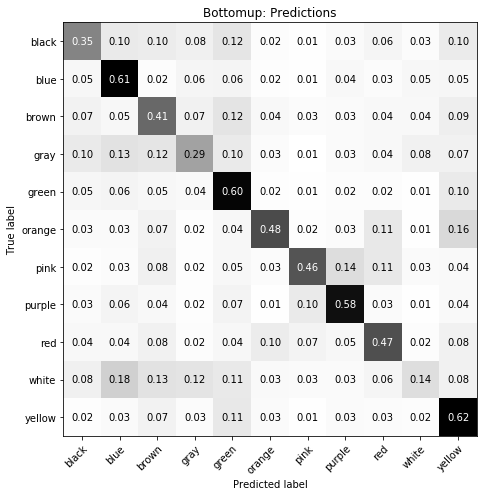

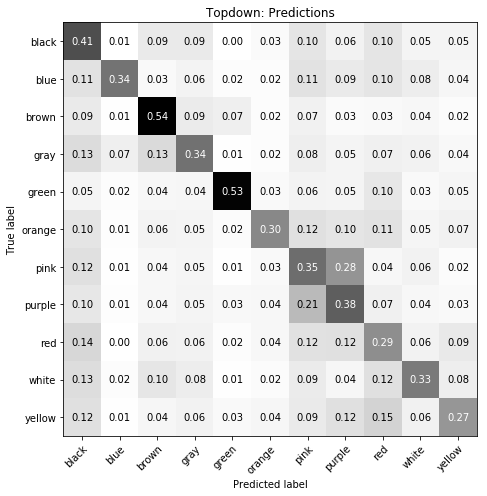

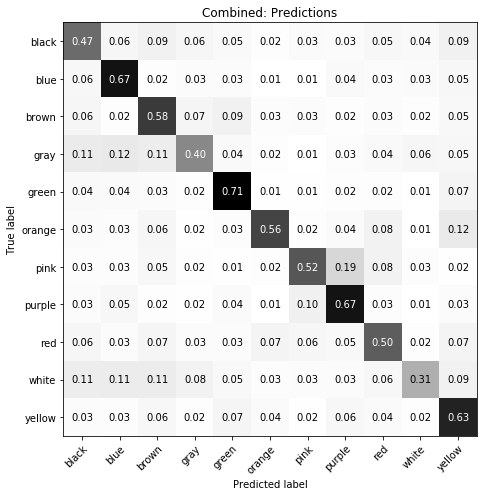





25000 




/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Train-Items: 275000
Items pro Klasse: {0: 25000, 1: 25000, 2: 25000, 3: 25000, 4: 25000, 5: 25000, 6: 25000, 7: 25000, 8: 25000, 9: 25000, 10: 25000}


/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Accuracy
bottomup:
Metric: accuracy
{'Alle Objekte': 0.45934554820581863}
{'Color-Diagnostic Objects': 0.5444550669216062}
{'Color-Biased Objects': 0.41459781529294937}
{'Color-Neutral Objects': 0.5101910828025478}


topdown:
Metric: accuracy
{'Alle Objekte': 0.37083650412690977}
{'Color-Diagnostic Objects': 0.765774378585086}
{'Color-Biased Objects': 0.304369414101291}
{'Color-Neutral Objects': 0.22006369426751593}


combined:
Metric: accuracy
{'Alle Objekte': 0.5485570450155125}
{'Color-Diagnostic Objects': 0.7667304015296367}
{'Color-Biased Objects': 0.45928500496524327}
{'Color-Neutral Objects': 0.5296178343949045}




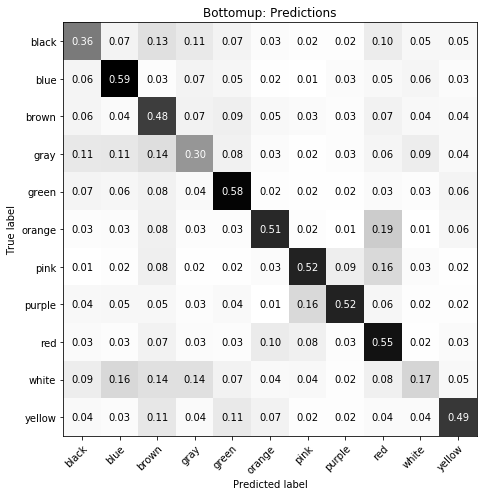

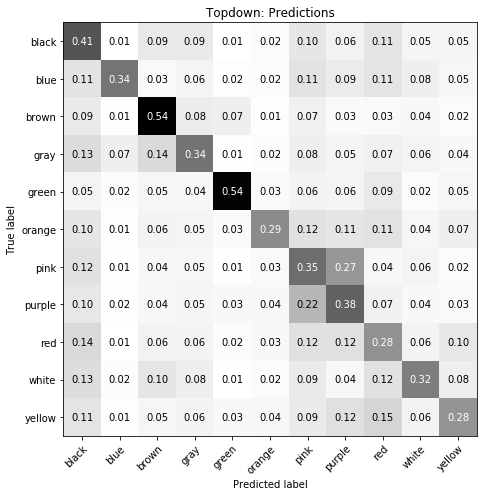

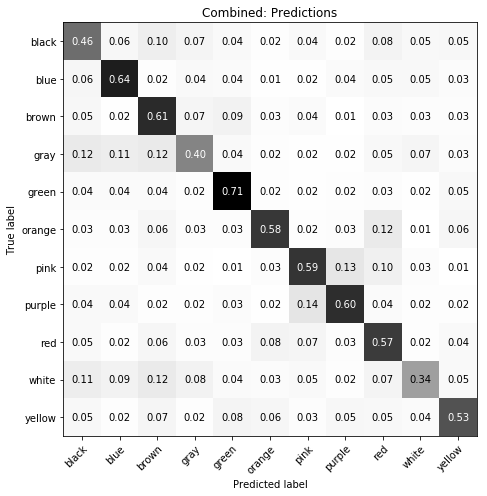





30000 




/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Train-Items: 330000
Items pro Klasse: {0: 30000, 1: 30000, 2: 30000, 3: 30000, 4: 30000, 5: 30000, 6: 30000, 7: 30000, 8: 30000, 9: 30000, 10: 30000}


/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Accuracy
bottomup:
Metric: accuracy
{'Alle Objekte': 0.42773517532049404}
{'Color-Diagnostic Objects': 0.494263862332696}
{'Color-Biased Objects': 0.3624627606752731}
{'Color-Neutral Objects': 0.4872611464968153}


topdown:
Metric: accuracy
{'Alle Objekte': 0.37171457004039105}
{'Color-Diagnostic Objects': 0.765774378585086}
{'Color-Biased Objects': 0.3058589870903674}
{'Color-Neutral Objects': 0.2213375796178344}


combined:
Metric: accuracy
{'Alle Objekte': 0.5336299244863314}
{'Color-Diagnostic Objects': 0.7676864244741873}
{'Color-Biased Objects': 0.4528301886792453}
{'Color-Neutral Objects': 0.5031847133757962}




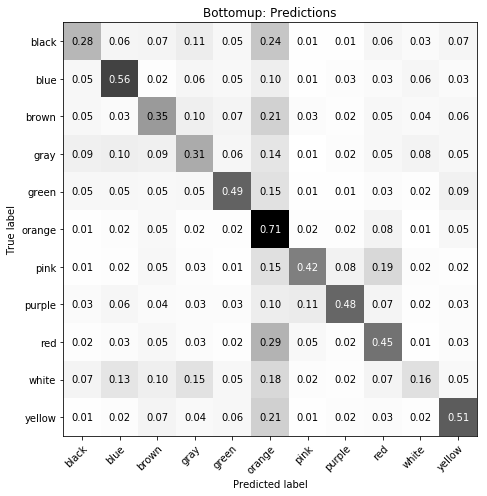

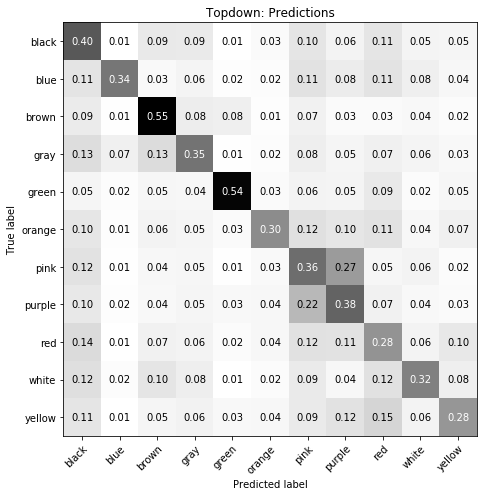

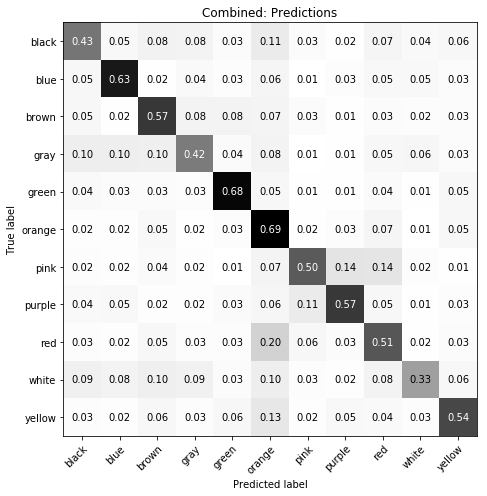

In [7]:
for n in [5000,10000,15000,20000,25000,30000]:
    print (n, '\n\n')
    td_train_x, td_train_y = get_sample(n)
    
    train_items = td_train_y[:,1:].argmax(axis=1)
    print ('Train-Items: {items}\nItems pro Klasse: {classes}'
           .format(items=len(train_items),classes=dict(Counter(train_items)))
          )
    
    topdown_predict = topdown_predictions(td_train_x, td_train_y)
    bottomup_predict = bottomup_predictions(td_train_y)
    test_predictions(bottomup_predict, topdown_predict)
    print ('\n\n\n')